# DPU example: Resnet50 using Pybind11
----

## Aim/s
* This notebooks shows an example of DPU applications.
* We will show how to leverage **Pybind11** to call **C++** VART API.

## References
* [Vitis AI Github Repository](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).

## Last revised
* Mar 10, 2021
    * Initial revision
* Dec 09, 2021
    * Updated compilation flags
* Oct 19, 2022
    * Updated compilation flags -- python3.10
----

## 1. Prepare the overlay
We will download the overlay onto the board.

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")
xmodel_file ="dpu_resnet50.xmodel"

## 2. Run C++ Program

Let's first check the original pictures.

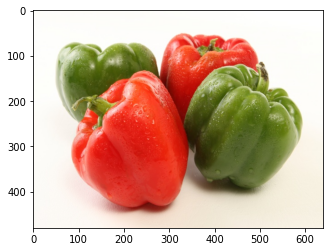

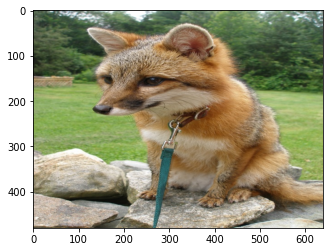

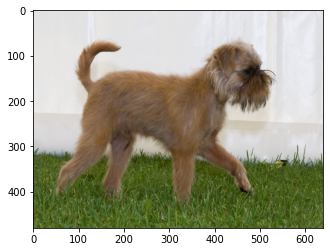

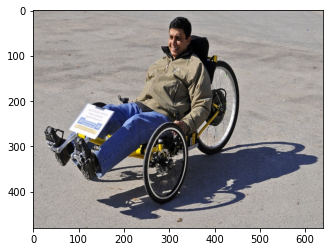

In [2]:
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img_folder = "./img/"
types = ('*.jpeg', '*.jpg', '*.png', '*.JPEG', '*.JPG', '*.PNG')
image_files = []
for files in types:
    image_files.extend(glob.glob(img_folder + files))
for i in sorted(image_files):
    image = cv2.imread(i)
    _, ax = plt.subplots(1)
    _ = ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

With the `pynq_dpu` package, users should be able to directly write C++
code in the Jupyter notebook cell, and compile it automatically using
[pybind11](https://pybind11.readthedocs.io/en/stable/). In this notebook
we will show how we leverage this to run DPU programs. 

Let's first define a few compilation flags. The flags are taken from
the [build.sh](https://github.com/Xilinx/Vitis-AI/blob/v1.3/demo/VART/resnet50/build.sh)
in the Vitis AI Github, and from running `!python3.8-config --cflags --embed` and 
`!python3.10-config --ldflags --embed` for the Python3.8 flags.

In [3]:
cflags = "-O2 -fno-inline -std=c++17 -L/usr/lib -Wl,-rpath=/usr/lib -I/usr/include/opencv4/opencv -I/usr/include/opencv4 " + \
         "-I/usr/include/python3.10 -I/usr/include/python3.10 -fPIC -shared "
ldflags = "-lvart-runner -lopencv_videoio -lopencv_imgcodecs " + \
    "-lopencv_highgui -lopencv_imgproc -lopencv_core -lglog " + \
    "-lxir -lunilog -lpthread -L/usr/lib/python3.10/config-3.10-aarch64-linux-gnu -L/usr/lib -lpython3.10 "

In the next cell, we will use IPython magic to write a hpp file **common.h** in the current working directory. This is needed when pybind11 compiles resnet50 as you can see later.

In [4]:
%%writefile common.h

struct TensorShape {
  unsigned int height;
  unsigned int width;
  unsigned int channel;
  unsigned int size;
};

struct GraphInfo {
  struct TensorShape* inTensorList;
  struct TensorShape* outTensorList;
  std::vector<int> output_mapping;
};


inline float get_input_scale(const xir::Tensor* tensor) {
  int fixpos = tensor->template get_attr<int>("fix_point");
  return std::exp2f(1.0f * (float)fixpos);
}

inline float get_output_scale(const xir::Tensor* tensor) {
  int fixpos = tensor->template get_attr<int>("fix_point");
  return std::exp2f(-1.0f * (float)fixpos);
}

inline std::vector<std::unique_ptr<xir::Tensor>> cloneTensorBuffer(
    const std::vector<const xir::Tensor*>& tensors){
    auto ret = std::vector<std::unique_ptr<xir::Tensor>>{};
    auto type = xir::DataType::XINT;
    ret.reserve(tensors.size());
    for (const auto& tensor : tensors) {
            ret.push_back(std::unique_ptr<xir::Tensor>(xir::Tensor::create(
                tensor->get_name(), tensor->get_shape(), xir::DataType{type, 8u})));
    }
    return ret;
}

inline std::vector<const xir::Subgraph*> get_dpu_subgraph(
    const xir::Graph* graph){
    auto root = graph->get_root_subgraph();
    auto children = root->children_topological_sort();
    auto ret = std::vector<const xir::Subgraph*>();
    for (auto c : children) {
        CHECK(c->has_attr("device"));
        auto device = c->get_attr<std::string>("device");
        if (device == "DPU") {
            ret.emplace_back(c);
        }
    }
    return ret;
}

class CpuFlatTensorBuffer : public vart::TensorBuffer {
    public:
        explicit CpuFlatTensorBuffer(void* data, const xir::Tensor* tensor)
            : TensorBuffer{tensor}, data_{data} {}
        virtual ~CpuFlatTensorBuffer() = default;

    public:
        virtual std::pair<uint64_t, size_t> data(
        const std::vector<int> idx) override {
            uint32_t size = std::ceil(
                tensor_->get_data_type().bit_width / 8.f);
            if (idx.size() == 0) {
                return {reinterpret_cast<uint64_t>(data_),
                        tensor_->get_element_num() * size};
            }
            auto dims = tensor_->get_shape();
            auto offset = 0;
            for (auto k = 0; k < dims.size(); k++) {
                auto stride = 1;
                for (auto m = k + 1; m < dims.size(); m++) {
                    stride *= dims[m];
                }
                offset += idx[k] * stride;
            }
            auto elem_num = tensor_->get_element_num();
            return {reinterpret_cast<uint64_t>(data_) + offset * size,
                    (elem_num - offset) * size};
        }
        private:
            void* data_;
};

Overwriting common.h


We will add the above flags into the following cell along with the magic.

The source code in the cell below is take from the 
[common.cpp](https://github.com/Xilinx/Vitis-AI/tree/v1.4/demo/VART/common/common.cpp),
[common.h](https://github.com/Xilinx/Vitis-AI/tree/v1.4/demo/VART/common/common.h),
and [main.cc](https://github.com/Xilinx/Vitis-AI/tree/v1.4/demo/VART/resnet50/src/main.cc)
in the Vitis AI Github. If you compare these programs, you may notice that we 
have made minor changes:

1. We integrated all programs which are from common.cpp into the same cell. This will ease the linking of the object files.
2. `vart::Runner` is from pre-defined library, which is not natively supported by Pybind11 cast types;
so we do explicit type conversions between void pointers and `vart::Runner` pointers.

The following cell will compile the C++ code into a shared object. 
<div class="alert alert-heading alert-info">
The compilation can take up to 30 seconds; please be patient.
</div>

In [5]:
%%pybind11 resnet50;{cflags};{ldflags}
#include <dirent.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/stat.h>
#include <unistd.h>
#include <cmath>
#include <cstdio>
#include <fstream>
#include <iomanip>
#include <iostream>
#include <queue>
#include <string>
#include <vector>
#include <numeric>
#include <glog/logging.h>
#include <mutex>
#include <vart/mm/host_flat_tensor_buffer.hpp>
#include <vart/runner.hpp>
#include <xir/graph/graph.hpp>
#include <xir/tensor/tensor.hpp>
#include <xir/util/data_type.hpp>

#include "common.h"
#include <opencv2/opencv.hpp>

using namespace std;
using namespace cv;

int getTensorShape(void* task_v, GraphInfo* shapes, int cntin,
                   int cntout) {
    vart::Runner* runner = (vart::Runner*)task_v;
    auto outputTensors = runner->get_output_tensors();
    auto inputTensors = runner->get_input_tensors();
    if (shapes->output_mapping.empty()) {
        shapes->output_mapping.resize((unsigned)cntout);
        std::iota(shapes->output_mapping.begin(), 
                  shapes->output_mapping.end(), 0);
    }
    for (int i = 0; i < cntin; i++) {
        auto dim_num = inputTensors[i]->get_shape().size();
        if (dim_num == 4) {
            shapes->inTensorList[i].channel = 
                inputTensors[i]->get_shape().at(3);
            shapes->inTensorList[i].width = 
                inputTensors[i]->get_shape().at(2);
            shapes->inTensorList[i].height = 
                inputTensors[i]->get_shape().at(1);
            shapes->inTensorList[i].size =
                inputTensors[i]->get_element_num() / 
                inputTensors[0]->get_shape().at(0);
        } else if (dim_num == 2) {
            shapes->inTensorList[i].channel = 
                inputTensors[i]->get_shape().at(1);
            shapes->inTensorList[i].width = 1;
            shapes->inTensorList[i].height = 1;
            shapes->inTensorList[i].size = 
                inputTensors[i]->get_element_num() / 
                inputTensors[0]->get_shape().at(0);
        }
    }
    for (int i = 0; i < cntout; i++) {
        auto dim_num = 
            outputTensors[shapes->output_mapping[i]]->get_shape().size();
        if (dim_num == 4) {
            shapes->outTensorList[i].channel = 
                outputTensors[shapes->output_mapping[i]]->get_shape().at(3);
            shapes->outTensorList[i].width =
            outputTensors[shapes->output_mapping[i]]->get_shape().at(2);
            shapes->outTensorList[i].height = 
                outputTensors[shapes->output_mapping[i]]->get_shape().at(1);
            shapes->outTensorList[i].size =
                outputTensors[shapes->output_mapping[i]]->get_element_num() /
                outputTensors[shapes->output_mapping[0]]->get_shape().at(0);
        } else if (dim_num == 2) {
            shapes->outTensorList[i].channel = 
                outputTensors[shapes->output_mapping[i]]->get_shape().at(1);
            shapes->outTensorList[i].width = 1;
            shapes->outTensorList[i].height = 1;
            shapes->outTensorList[i].size = 
                outputTensors[shapes->output_mapping[i]]->get_element_num() /
            outputTensors[shapes->output_mapping[0]]->get_shape().at(0);
        }
    }
    return 0;
}

static int find_tensor(std::vector<const xir::Tensor*> tensors,
                       const std::string& name) {
    int ret = -1;
    for (auto i = 0u; i < tensors.size(); ++i) {
        if (tensors[i]->get_name().find(name) != std::string::npos) {
            ret = (int)i;
            break;
        }
    }
    return ret;
}

int getTensorShape2(void* task_v, GraphInfo* shapes, int cntin,
                   std::vector<std::string> output_names) {
    vart::Runner* runner = (vart::Runner*)task_v;
    for (auto i = 0u; i < output_names.size(); ++i) {
        auto idx = find_tensor(runner->get_output_tensors(), output_names[i]);
        shapes->output_mapping.push_back(idx);
    }
    getTensorShape((void*)runner, shapes, cntin, (int)output_names.size());
    return 0;
}

void ListImages(string const &path, vector<string> &images) {
    images.clear();
    struct dirent *entry;

    struct stat s;
    lstat(path.c_str(), &s);
    if (!S_ISDIR(s.st_mode)) {
        fprintf(stderr, "Error: %s is not a valid directory!\n", 
                path.c_str());
        exit(1);
    }

    DIR *dir = opendir(path.c_str());
    if (dir == nullptr) {
        fprintf(stderr, "Error: Open %s path failed.\n", path.c_str());
        exit(1);
    }

    while ((entry = readdir(dir)) != nullptr) {
        if (entry->d_type == DT_REG || entry->d_type == DT_UNKNOWN) {
            string name = entry->d_name;
            string ext = name.substr(name.find_last_of(".") + 1);
            if ((ext == "JPEG") || (ext == "jpeg") || (ext == "JPG") ||
                (ext == "jpg") || (ext == "PNG") || (ext == "png")) {
                images.push_back(name);
            }
        }
    }

    closedir(dir);
    sort(images.begin(), images.end());
}

void LoadWords(string const &path, vector<string> &kinds) {
    kinds.clear();
    fstream fkinds(path);
    if (fkinds.fail()) {
        fprintf(stderr, "Error : Open %s failed.\n", path.c_str());
        exit(1);
    }
    string kind;
    while (getline(fkinds, kind)) {
        kinds.push_back(kind);
    }

    fkinds.close();
}

void CPUCalcSoftmax(const int8_t* data, size_t size, float* result,
                    float scale) {

  assert(data && result);
  double sum = 0.0f;

  for (size_t i = 0; i < size; i++) {
    result[i] = exp((float)data[i] * scale);
    sum += result[i];
  }
  for (size_t i = 0; i < size; i++) {
    result[i] /= sum;
  }
}

void TopK(const float *d, int size, int k, vector<string> &vkinds) {
    assert(d && size > 0 && k > 0);
    priority_queue<pair<float, int>> q;
    
    for (auto i = 0; i < size; ++i) {
        q.push(pair<float, int>(d[i], i));
    }

    for (auto i = 0; i < k; ++i) {
        pair<float, int> ki = q.top();
        printf("top[%d] prob = %-8f  name = %s\n", i, d[ki.second],
        vkinds[ki.second].c_str());
        q.pop();
    }
}

void runResnet50(void* task_v, string baseImagePath, GraphInfo* shapes) {
    vart::Runner* runner = (vart::Runner*)task_v;
    vector<string> kinds, images;
    ListImages(baseImagePath, images);
    if (images.size() == 0) {
        cerr << "\nError: No images existing under " << baseImagePath << endl;
        return;
    }

    LoadWords(baseImagePath + "words.txt", kinds);
    if (kinds.size() == 0) {
        cerr << "\nError: No words exist in file words.txt." << endl;
        return;
    }
    float mean[3] = {104, 107, 123};
    auto outputTensors = runner->get_output_tensors();
    auto inputTensors = runner->get_input_tensors();
    auto out_dims = outputTensors[0]->get_shape();
    auto in_dims = inputTensors[0]->get_shape();

    auto input_scale = get_input_scale(inputTensors[0]);
    auto output_scale = get_output_scale(outputTensors[0]);
    
    int outSize = shapes->outTensorList[0].size;
    int inSize = shapes->inTensorList[0].size;
    int inHeight = shapes->inTensorList[0].height;
    int inWidth = shapes->inTensorList[0].width;
    
    int batchSize = in_dims[0];
    
    std::vector<std::unique_ptr<vart::TensorBuffer>> inputs, outputs;
    vector<Mat> imageList;
    int8_t* imageInputs = new int8_t[inSize * batchSize];
    float* softmax = new float[outSize];
    int8_t* FCResult = new int8_t[batchSize * outSize];
    std::vector<vart::TensorBuffer*> inputsPtr, outputsPtr;
    std::vector<std::shared_ptr<xir::Tensor>> batchTensors;
    
    for (unsigned int n = 0; n < images.size(); n += batchSize) {
        unsigned int runSize = 
        (images.size() < (n + batchSize)) ? (images.size() - n) : batchSize;
        in_dims[0] = runSize;
        out_dims[0] = batchSize;
        for (unsigned int i = 0; i < runSize; i++) {
            Mat image = imread(baseImagePath + images[n + i]);
            
            Mat image2;
            resize(image, image2, Size(inHeight, inWidth), 0, 0);
            for (int h = 0; h < inHeight; h++) {
                for (int w = 0; w < inWidth; w++) {
                    for (int c = 0; c < 3; c++)
                        imageInputs[i*inSize + h*inWidth*3 + w*3 + c] =
                        (int8_t)((image2.at<Vec3b>(h, w)[c] - mean[c]) * input_scale);
                }
            }
            imageList.push_back(image);
        }
        batchTensors.push_back(std::shared_ptr<xir::Tensor>(
           xir::Tensor::create(inputTensors[0]->get_name(), in_dims,
                               xir::DataType{xir::DataType::XINT, 8u})));
        inputs.push_back(std::make_unique<CpuFlatTensorBuffer>(
            imageInputs, batchTensors.back().get()));
            batchTensors.push_back(std::shared_ptr<xir::Tensor>(
               xir::Tensor::create(outputTensors[0]->get_name(), out_dims,
                                   xir::DataType{xir::DataType::XINT, 8u})));
        outputs.push_back(std::make_unique<CpuFlatTensorBuffer>(
            FCResult, batchTensors.back().get()));
        inputsPtr.clear();
        outputsPtr.clear();
        inputsPtr.push_back(inputs[0].get());
        outputsPtr.push_back(outputs[0].get());
        
        auto job_id = runner->execute_async(inputsPtr, outputsPtr);
        runner->wait(job_id.first, -1);
        for (unsigned int i = 0; i < runSize; i++) {
            cout << "\nImage : " << images[n + i] << endl;
            CPUCalcSoftmax(&FCResult[i * outSize], outSize, softmax, output_scale);
            TopK(softmax, outSize, 5, kinds);
        }
        imageList.clear();
        inputs.clear();
        outputs.clear();
    }
    delete[] FCResult;
    delete[] imageInputs;
    delete[] softmax;

}

int run(char* XModel, string baseImagePath) {
    GraphInfo shapes;
    auto graph = xir::Graph::deserialize(XModel);
    auto subgraph = get_dpu_subgraph(graph.get());
    auto runner = vart::Runner::create_runner(subgraph[0], "run");
    auto inputTensors = runner->get_input_tensors();
    auto outputTensors = runner->get_output_tensors();
    
    int inputCnt = inputTensors.size();
    int outputCnt = outputTensors.size();
    TensorShape inshapes[inputCnt];
    TensorShape outshapes[outputCnt];
    shapes.inTensorList = inshapes;
    shapes.outTensorList = outshapes;
    getTensorShape((void*)(runner.get()), &shapes, inputCnt, outputCnt);

    runResnet50((void*)(runner.get()),baseImagePath, &shapes);

    return 0;
}

Now `resnet50` can be imported as a Python module. 

We leverage the [existing Python package `wurlitzer`](https://github.com/minrk/wurlitzer) so we can capture the 
C++ outputs into the Jupyter notebook. You should be able to see the printout
from the C++ program. 

In [6]:
from wurlitzer import sys_pipes
import resnet50

with sys_pipes():
    resnet50.run(xmodel_file,img_folder)


Image : bellpeppe-994958.JPEG
top[0] prob = 0.992235  name = bell pepper
top[1] prob = 0.003158  name = acorn squash
top[2] prob = 0.001915  name = cucumber, cuke
top[3] prob = 0.000905  name = zucchini, courgette
top[4] prob = 0.000549  name = strawberry

Image : greyfox-672194.JPEG
top[0] prob = 0.512263  name = grey fox, gray fox, Urocyon cinereoargenteus
top[1] prob = 0.398951  name = red fox, Vulpes vulpes
top[2] prob = 0.032748  name = kit fox, Vulpes macrotis
top[3] prob = 0.015469  name = coyote, prairie wolf, brush wolf, Canis latrans
top[4] prob = 0.012047  name = red wolf, maned wolf, Canis rufus, Canis niger

Image : irishterrier-696543.JPEG
top[0] prob = 0.455770  name = Border terrier
top[1] prob = 0.276438  name = Brabancon griffon
top[2] prob = 0.130580  name = Irish terrier
top[3] prob = 0.048038  name = cairn, cairn terrier
top[4] prob = 0.022691  name = affenpinscher, monkey pinscher, monkey dog

Image : jinrikisha-911722.JPEG
top[0] prob = 0.583169  name = tricycle

You can try the same program with other values of `img_folder`.
Note that you need:

1. Make sure you have the `words.txt` containing the class names
stored in the same folder.
2. The path specified by `img_folder` has to end with `/`.

Clean up by deleting the overlay object.

In [7]:
del overlay

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----